## Problem set 6

## Name: [Yawen Tan]

## Link to your PS6 github repo: [https://github.com/IsabellaTan/Brown-DATA1030-HW6]

### Problem 0 

-2 points for every missing green OK sign. 

Make sure you are in the DATA1030 environment.

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.10"):
    print(FAIL, "Python version 3.12.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "2.2.5", 'matplotlib': "3.10.1",'sklearn': "1.6.1", 
                'pandas': "2.2.3",'xgboost': "3.0.0", 'shap': "0.47.2", 
                'polars': "1.27.1", 'seaborn': "0.13.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.10

[ OK ] numpy version 2.2.5 is installed.
[ OK ] matplotlib version 3.10.1 is installed.
[ OK ] sklearn version 1.6.1 is installed.
[ OK ] pandas version 2.2.3 is installed.
[ OK ] xgboost version 3.0.0 is installed.
[ OK ] shap version 0.47.2 is installed.
[ OK ] polars version 1.27.1 is installed.
[ OK ] seaborn version 0.13.2 is installed.


## Problem 1 (5 points)

Write a function called `linear_ML_pipeline` which takes training, validation, test sets, and a boolean variable called `is_classif` as input. The variable `is_classif` is `True` if the target variable is categorial (classification problem), and `False` if the target variable is continuous (regression problem). The function also takes the following lists as inputs:
- continuous_ftrs: the column names of continuous features
- ordinal_ftrs: the column names of ordinal features
- ordinal_cats: the ordered list of categories for each ordinal feature
- categorical_ftrs: the column names of categorical features

Within the function, perform the following steps:
- write the docstring
- test the inputs! write at least 10 tests. make sure that among other things, all features are accounted for in the lists.
- preprocess the sets using sklearn and make sure to fit_transform the training set, and transform the validation and test sets
- fit a logistic regression model if `is_classif` is `True`, a linear regression model otherwise
- use the elastic net regularization and tune both hyperparameters (alpha or C and l1_ratio)
- perform CV and select the hyperparameter combo which optimizes the validation score
- calculate the test score
- your function should return the best model, its hyperparameters, and the test score

You will use this function to solve problems 2 and 3. Data splitting will be performed before the function is called.

In [2]:
# add your code here

def linear_ML_pipeline(X_train, y_train, X_val, y_val, X_test, y_test, is_classif, continuous_ftrs, ordinal_ftrs, ordinal_cats, categorical_ftrs, random_state=42):

    '''
    Build and evaluate a complete linear-model pipeline that supports both
    classification (Logistic Regression) and regression (Elastic Net),
    with preprocessing, elastic-net regularization, manual hyperparameter tuning
    over a grid, validation-based model selection, and final test evaluation.

    Parameters:
    -----------
    X_train : pandas.DataFrame
        Feature matrix for the training split. Columns must match X_val and X_test
        exactly (same names and order).
    y_train : pandas.Series or 1D array-like
        Target vector for the training split.
    X_val : pandas.DataFrame
        Feature matrix for the validation split (used to select hyperparameters).
    y_val : pandas.Series or 1D array-like
        Target vector for the validation split.
    X_test : pandas.DataFrame
        Feature matrix for the test split (held out for final evaluation only).
    y_test : pandas.Series or 1D array-like
        Target vector for the test split.
    is_classif : bool
        If True, fit a Logistic Regression model (elastic net penalty) for a
        classification task; if False, fit an ElasticNet regressor for a
        regression task.
    continuous_ftrs : list[str]
        Column names (in X_*) that are continuous features to be standardized
        (mean=0, std=1).
    ordinal_ftrs : list[str]
        Column names (in X_*) that are ordinal categorical features to be
        encoded via OrdinalEncoder using the specified order in `ordinal_cats`.
    ordinal_cats : list[list[Any]]
        Ordered categories for each ordinal feature. The i-th list provides the
        category order for ordinal_ftrs[i].
    categorical_ftrs : list[str]
        Column names (in X_*) that are nominal (unordered) categorical features
        to be encoded via OneHotEncoder(handle_unknown='ignore').
    random_state : int, default=42
        Random seed used where applicable (e.g., solvers), to ensure reproducibility.

    Returns:
    --------
    best_model : sklearn estimator (already fitted)
        The model refit on TRAIN+VAL using the best hyperparameters discovered
        on the validation set (classification: LogisticRegression with penalty='elasticnet'
        and solver='saga'; regression: ElasticNet).
    best_hyperparams : dict
        The best hyperparameter combination found on the validation set. Includes
        at least {'l1_ratio': ..., 'C': ...} for classification or
        {'l1_ratio': ..., 'alpha': ...} for regression, and any other key settings
        needed to reproduce the best model.
    test_score : float
        Final performance on the held-out test set. For classification, accuracy;
        for regression, R^2. (These defaults follow the introductory course
        conventions.)

    Example:
    --------
    >>> # Suppose you already split your data and defined feature groups:
    >>> best_model, best_params, test_score = linear_ML_pipeline(
    ...     X_train, y_train, X_val, y_val, X_test, y_test,
    ...     is_classif=True,
    ...     continuous_ftrs=['age','capital_gain','capital_loss','hours_per_week'],
    ...     ordinal_ftrs=['education'],
    ...     ordinal_cats=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',
    ...                    ' 10th',' 11th',' 12th',' HS-grad',' Some-college',
    ...                    ' Assoc-voc',' Assoc-acdm',' Bachelors',' Masters',
    ...                    ' Prof-school',' Doctorate']],
    ...     categorical_ftrs=['workclass','marital-status','occupation',
    ...                       'relationship','race','sex','native-country'],
    ...     random_state=42
    ... )
    >>> best_params
    {'penalty': 'elasticnet', 'solver': 'saga', 'C': 1.0, 'l1_ratio': 0.5, 'max_iter': 10000}
    >>> test_score
    0.85  # accuracy on the held-out test set (example)
    '''
    # import library
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression, ElasticNet
    from sklearn.model_selection import ParameterGrid
    from sklearn.metrics import accuracy_score, r2_score, mean_squared_error


    # TEST
    #----------------------------------------------------------------
    # Test 1: if X_train, X_val, X_test are not pandas DataFrames, raise ValueError
    if not all(isinstance(x, pd.DataFrame) for x in [X_train, X_val, X_test]):
        raise ValueError("X_train, X_val, and X_test must all be pandas DataFrames")

    # Test 2: if y_train, y_val, y_test are not pandas Series, raise ValueError
    if not all(isinstance(y, (pd.Series, np.ndarray, list)) for y in [y_train, y_val, y_test]):
        raise ValueError("y_train, y_val, and y_test must each be a pandas Series, numpy array, or list")

    # Test 3: if any of the feature DataFrames are empty (0 rows or 0 columns), raise ValueError
    for name, df in zip(["X_train", "X_val", "X_test"], [X_train, X_val, X_test]):
        if df.shape[0] == 0:
            raise ValueError(f"{name} has 0 rows")
        if df.shape[1] == 0:
            raise ValueError(f"{name} has 0 columns")

    # Test 4: ensure column names and order match across X_train, X_val, X_test
    if list(X_train.columns) != list(X_val.columns) or list(X_train.columns) != list(X_test.columns):
        raise ValueError("Column names and order must be identical across X_train, X_val, and X_test")

    # Test 5: ensure feature lists are all Python lists
    for var_name, var in {
        "continuous_ftrs": continuous_ftrs,
        "ordinal_ftrs": ordinal_ftrs,
        "ordinal_cats": ordinal_cats,
        "categorical_ftrs": categorical_ftrs,
    }.items():
        if not isinstance(var, list):
            raise ValueError(f"{var_name} must be provided as a list")

    # Test 6: check that every feature column is accounted for exactly once
    all_features = continuous_ftrs + ordinal_ftrs + categorical_ftrs
    if set(all_features) != set(X_train.columns):
        missing = set(X_train.columns) - set(all_features)
        extra = set(all_features) - set(X_train.columns)
        raise ValueError(f"Feature mismatch: missing {missing}, extra {extra}")

    # Test 7: check for overlaps among feature groups
    if (set(continuous_ftrs) & set(ordinal_ftrs)) or \
       (set(continuous_ftrs) & set(categorical_ftrs)) or \
       (set(ordinal_ftrs) & set(categorical_ftrs)):
        raise ValueError("continuous_ftrs, ordinal_ftrs, and categorical_ftrs must not overlap")

    # Test 8: ensure ordinal_ftrs and ordinal_cats have the same length
    if len(ordinal_ftrs) != len(ordinal_cats):
        raise ValueError("Length of ordinal_cats must match the number of ordinal_ftrs")

    # Test 9: ensure continuous_ftrs is not empty
    if continuous_ftrs == [] and ordinal_ftrs == [] and categorical_ftrs == []:
        raise ValueError("At least one feature list must be non-empty")

    # Test 10: ensure is_classif is a boolean
    if not isinstance(is_classif, bool):
        raise ValueError("is_classif must be a boolean value (True for classification, False for regression)")

    # Test 11: ensure target lengths match feature lengths
    for (x, y, name) in [(X_train, y_train, "train"), (X_val, y_val, "validation"), (X_test, y_test, "test")]:
        if len(x) != len(y):
            raise ValueError(f"Length mismatch between X_{name} and y_{name}")

    # Test 12: optional—check for duplicate columns in X_train
    if X_train.columns.duplicated().any():
        raise ValueError("Duplicate column names detected in X_train")


    # Data Preprocessing
    #----------------------------------------------------------------
    # Continuous features: StandardScaler
    continuous_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    # Ordinal features: OrdinalEncoder
    ordinal_transformer = Pipeline(steps=[('encoder', OrdinalEncoder(categories=ordinal_cats))])

    # Nominal (categorical) features: OneHotEncoder
    categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

    # Combine all three transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cont', continuous_transformer, continuous_ftrs),
            ('ord', ordinal_transformer, ordinal_ftrs),
            ('cat', categorical_transformer, categorical_ftrs)],
        remainder='drop'  # if feature list cover all the column, drop left feature
        )

    # Fit on training data, transform all sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)



    #  Model setup and Elastic Net regularization
    #----------------------------------------------------------------

    if is_classif:
        # Logistic Regression + Elastic Net Regularization
        base_model = LogisticRegression(
            penalty="elasticnet",
            solver="saga",
            max_iter=5000,
            random_state=random_state)

        # Parameter tuning
        param_grid = {
            "C": np.logspace(-2, 1, 2),       # [1e-2, 1, 1e2]
            "l1_ratio": np.linspace(0.1, 1.0, 5)}
        score_func = accuracy_score

    else:
        # Linear Regression：ElasticNet
        base_model = ElasticNet(
            max_iter=5000,
            random_state=random_state)

        # Parameter tuning
        param_grid = {
            "alpha": np.logspace(-2, 1, 2),   # [1e-2, 1, 1e2]
            "l1_ratio": np.linspace(0.1, 1.0, 5)}

        score_func = r2_score # use R square


    # Cross-validation, hyperparameter tuning, and model selection
    # ----------------------------------------------------------------
    best_val_score = -np.inf  # record the best score for validation set
    best_params = None
    best_model = None
    # set a list to store result
    results = []

    # Loop every combinition of parameter
    for params in ParameterGrid(param_grid):
        # Create new model for new parameter
        model = base_model.set_params(**params)
        # Fit the train data
        model.fit(X_train_prep, y_train)
        # Predit on train and validation data
        y_train_pred = model.predict(X_train_prep)
        y_val_pred = model.predict(X_val_prep)
        # Calcuate the score
        train_score = score_func(y_train, y_train_pred)
        val_score = score_func(y_val, y_val_pred)
        mse_val = None
        if not is_classif:
            mse_val = mean_squared_error(y_val, y_val_pred)
        # Store the result
        results.append({
            **params,
            "train_score": train_score,
            "val_score": val_score,
            "mse_val": mse_val
        })
        # Update best model
        if val_score > best_val_score:
            best_val_score = val_score
            best_params = params
            best_model = model

    # Refit best model on TRAIN+VAL, evaluate on TEST
    # ---------------------------------------------------------
    # Combine train and validation set
    X_trainval = np.vstack([X_train_prep, X_val_prep])
    y_trainval = np.concatenate([y_train, y_val])
    # use best parameter to train the model
    final_model = base_model.set_params(**best_params)
    final_model.fit(X_trainval, y_trainval)
    # predict on the test set and calculate the score
    y_test_pred = final_model.predict(X_test_prep)
    test_score = score_func(y_test, y_test_pred)

    # For regression: use R² as the final evaluation metric (consistent with lecture and default sklearn scoring)
    return final_model, best_params, test_score



## Problem 2: time series forecasting with VAR

You will practice multivariate time series forcasting using VAR - vector autoregression.

The `stocks_prices.csv` is in the data folder. It contains the stock prices of amazon (AMZN), microsoft (MSFT), and apple (AAPL). Here is a description of each column in the dataset:
- price ticker date: the date when the stock price was recorded - note that weekends and holidays are absent
- Close AAPL: apple stock price at closing time in USD (i.e., at the end of the trading day)
- Close AMZN: amazon stock price at closing time in USD (i.e., at the end of the trading day)
- Close MSFT: microsoft stock price at closing time in USD (i.e., at the end of the trading day)
- High AAPL: highest apple stock price during the trading day in USD
- High AMZN: highest amazon stock price during the trading day in USD
- High MSFT: highest microsoft stock price during the trading day in USD
- Low AAPL: lowest apple stock price during the trading day in USD
- Low AMZN: lowest amazon stock price during the trading day in USD
- Low MSFT: lowest microsoft stock price during the trading day in USD
- Open AAPL: apple stock price at opening time in USD (i.e., at the beginning of the trading day)
- Open AMZN: amazon stock price at opening time in USD (i.e., at the beginning of the trading day)
- Open MSFT: microsoft stock price opening time in USD (i.e., at the beginning of the trading day)
- Volume AAPL: total traded volume (buys and sells) of apple on the trading day in USD
- Volume AMZN: total traded volume (buys and sells) of amazon on the trading day in USD
- Volume MSFT: total traded volume (buys and sells) of microsoft on the trading day in USD

The goal of problem 2 is to predict the opening price of apple stocks one day ahead based on the time series observations.

### Problem 2a - feature matrix (15 points)
Perform the steps outlined in the cell below.

In [3]:
# add your code here
# import packages
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# read file
col_names = [
    "date",
    "close_aapl", "close_amzn", "close_msft",
    "high_aapl", "high_amzn", "high_msft",
    "low_aapl", "low_amzn", "low_msft",
    "open_aapl", "open_amzn", "open_msft",
    "volume_aapl", "volume_amzn", "volume_msft"]
# we write the data from 4th row and rename the column
df = pd.read_csv("data/stocks_prices.csv", skiprows=3, names=col_names)
# Convert date column to datetime, sort, and set as index
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date")
# Print header of dataframe
print(df.head())
# Select the opening prices of AAPL, AMZN, and MSFT as multivariate inputs for the VAR model, since the goal is to forecast AAPL's next-day opening price.
data = df[["open_aapl", "open_amzn", "open_msft"]].copy()


# write a function which takes the following input:
# - the dataframe, 
# - the name of the target column, 
# - a variable `p` which describes how many autoregresive past features we use (p in AR(p) of the lecture notes)
# the function should return a feature matrix X and target variable y after VAR is applied to the multivariate time series data
# make sure that the points are ordered with respect to time such that 
# the oldest observations are at the top and the most recent observation are at the bottom of the dataframe.

def build_VAR_features(dataframe, target_col, p):
    """
    Build a feature matrix X and target y for a multivariate VAR(p) model.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        Multivariate time series with all input variables (columns).
    target_col : str
        The column name of the variable we want to forecast (target).
    p : int
        Number of autoregressive lags (p in AR(p)).

    Returns
    -------
    X : pandas.DataFrame
        Feature matrix containing lagged values of all variables.
        Ordered such that oldest observations are at the top
        and most recent at the bottom.
    y : pandas.Series
        Target variable shifted by one step ahead of the input features.
    """
    # Set X be a dataframe
    X = pd.DataFrame()
    # For each lag from 1 to p, shift all columns downward by 'lag' steps and rename columns as varname_lag1, varname_lag2, etc.
    for lag in range(1, p + 1):
        lagged = dataframe.shift(lag).copy()
        lagged.columns = [f"{col}_lag{lag}" for col in dataframe.columns]
        X = pd.concat([X, lagged], axis=1)
    # Target is the original target column
    y = dataframe[target_col].copy()
    # Drop rows with missing values due to lagging
    X = X.dropna()
    y = y.loc[X.index]
    # Return ordered with time increasing
    return X, y




            close_aapl  close_amzn  close_msft  high_aapl  high_amzn  \
date                                                                   
2020-01-02   72.538490   94.900497  153.042297  72.598869  94.900497   
2020-01-03   71.833290   93.748497  151.136642  72.594055  94.309998   
2020-01-06   72.405670   95.143997  151.527328  72.444313  95.184502   
2020-01-07   72.065163   95.343002  150.145706  72.671356  95.694504   
2020-01-08   73.224411   94.598503  152.537323  73.526303  95.550003   

             high_msft   low_aapl   low_amzn    low_msft  open_aapl  \
date                                                                  
2020-01-02  153.147108  71.292281  93.207497  150.860341  71.545867   
2020-01-03  152.403898  71.608685  93.224998  150.603064  71.765667   
2020-01-06  151.594033  70.703005  93.000000  149.126212  70.954181   
2020-01-07  152.137101  71.845385  94.601997  149.897978  72.415353   
2020-01-08  153.213833  71.768086  94.321999  150.498284  71.768086  

### Problem 2b - splitting (10 points)
We will split the dataset in a couple of different ways to study information leakage. Perform the steps outlined in the cell below.

In [4]:
# add your code here

# import library
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Call build_VAR_features to get X and y
X, y = build_VAR_features(data, target_col="open_aapl", p=3)

# split 1: create shuffled train/validation/test sets (60/20/20 ratio) and run `linear_ML_pipeline` on it. 
# print out the best hyperparameter values, and the test score
# repeat this process with 5 random states
# print out the best hyperparameter values, and the test score
# print out the mean and stdev of the 5 test scores.
print("\n--------------------------------")
print(" SPLIT 1: Random shuffled split")
print("--------------------------------\n")
# Create a list to store test score
test_scores_rand = []
# Loop for 5 random states
for seed in range(5):
    # Split 60% training data, 20% validation data and 20% test data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, shuffle=True, random_state=seed)

    best_model, best_params, test_score = linear_ML_pipeline(
        X_train, y_train, X_val, y_val, X_test, y_test,
        is_classif=False, # not classification problem
        continuous_ftrs=list(X.columns),  # all the features are continuous
        ordinal_ftrs=[], ordinal_cats=[], categorical_ftrs=[]
    )
    test_scores_rand.append(test_score)
    print("Best Hyperparameter and Test R-square: "
        f"best alpha={float(best_params['alpha']):.3f}, "
      f"l1_ratio={float(best_params['l1_ratio']):.2f}, "
      f"test R2={test_score:.4f}")

# print mean and stdev
print(f"\nRandom split: mean test R² = {np.mean(test_scores_rand):.4f}, "
      f"std = {np.std(test_scores_rand):.4f}")


# split 2: place 20% of the most recent observations in the test set, 
# then apply sklearn's TimeSeriesSplit on the rest of the data with n_splits = 5
# run `linear_ML_pipeline` on each split.
# print out the best hyperparameter values, and the test score
# print out the mean and stdev of the 5 test scores.
print("\n--------------------------------")
print(" SPLIT 2: Time-series split")
print("--------------------------------\n")

test_scores_time = []

# let the last 20% data be test set
n_test = int(0.2 * len(X))
X_trainval, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
y_trainval, y_test = y.iloc[:-n_test], y.iloc[-n_test:]
# Using TimeSeriesSplit to do the cross validation on the test of data set 'trainval'
tscv = TimeSeriesSplit(n_splits=5) # n_splits = 5
# Loop over each split
for i, (train_idx, val_idx) in enumerate(tscv.split(X_trainval)):
    # spilt the data
    X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    best_model, best_params, test_score = linear_ML_pipeline(
        X_train, y_train, X_val, y_val, X_test, y_test,
        is_classif=False,
        continuous_ftrs=list(X.columns),
        ordinal_ftrs=[], ordinal_cats=[], categorical_ftrs=[]
    )
    test_scores_time.append(test_score)
    print("Best Hyperparameter and Test R-square: "
        f"best alpha={float(best_params['alpha']):.3f}, "
      f"l1_ratio={float(best_params['l1_ratio']):.2f}, "
      f"test R2={test_score:.4f}")

print(f"\nTimeSeriesSplit: mean test R² = {np.mean(test_scores_time):.4f}, "
      f"std = {np.std(test_scores_time):.4f}")



--------------------------------
 SPLIT 1: Random shuffled split
--------------------------------

Best Hyperparameter and Test R-square: best alpha=0.010, l1_ratio=1.00, test R2=0.9957
Best Hyperparameter and Test R-square: best alpha=0.010, l1_ratio=1.00, test R2=0.9956
Best Hyperparameter and Test R-square: best alpha=0.010, l1_ratio=1.00, test R2=0.9945
Best Hyperparameter and Test R-square: best alpha=0.010, l1_ratio=0.78, test R2=0.9959
Best Hyperparameter and Test R-square: best alpha=0.010, l1_ratio=0.78, test R2=0.9953

Random split: mean test R² = 0.9954, std = 0.0005

--------------------------------
 SPLIT 2: Time-series split
--------------------------------

Best Hyperparameter and Test R-square: best alpha=0.010, l1_ratio=0.78, test R2=0.8952
Best Hyperparameter and Test R-square: best alpha=0.010, l1_ratio=1.00, test R2=0.9167
Best Hyperparameter and Test R-square: best alpha=0.010, l1_ratio=1.00, test R2=0.9166
Best Hyperparameter and Test R-square: best alpha=0.010, 

Discuss in this cell what you observe and answer the questions below:

- the mean and stdev of the test scores differ based on how you split the data. Explain in a few sentences why!

**your answer here**

The mean and standard deviation of the test R2 values differ because the two splitting methods capture different temporal structures in the data. In the random split, the training, validation, and test sets are randomly mixed, which causes data leakage，information from future time periods unintentionally enters the training set. This leakage allows the model to indirectly “see” future patterns, leading to artificially high R² scores (=0.995) and very low variance across random states. In contrast, the time-series split preserves the chronological order—training only on earlier data and testing on later observations—thus preventing data leakage and reflecting real forecasting conditions where future information is unavailable. As a result, the average R2 (=0.913) is lower and the variability is higher, but the evaluation is more realistic and reliable.

- Forecasting models like this can be used for trading. I.e., if your model predicts that the opening price of the apple stock tomorrow will be higher than the closing price today, you'd put in a sell order at the end of the day. If your prediction is correct, you will make a profit in USD once your order executes at tomorrow's open. Similarly, if your model predicts that the opening price of apple stock tomorrow will be lower than the closing price today, you'd put in a buy order. If your prediction is correct, you'll buy at a low price once your order executes at tomorrow's open. This is how you'd act based on the model's prediction - buy low, sell high. Would you be willing to use your own money to deploy the models developed in split 1 and/or split 2? Why or why not?

**your answer here**


I would not use my own money to trade based on either model. The random-split(split 1) model is clearly overfitted because it benefits from data leakage and produces unrealistically high performance. The time-series(split 2) model performs more reasonably but still relies solely on past opening prices, ignoring market volatility, external news and any other critical factors in real trading. Although the time-series model is more trustworthy than the random-split one, both lack robustness and domain awareness, so they would not be suitable for real-world investment decisions.



## Problem 3 - group structure

We will work with the [hand postures dataset](https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures) in problem 3. Please carefully read the dataset description and perform as much EDA as you can on this dataset. The EDA is not graded but it will help you to correctly answer 3a and 3b.

This dataset has group structure: 14 users performing 5 different hand postures while wearing sensors attached to a left-handed glove. Two different ML questions can be asked using this dataset. We will explore how splitting differs for both questions in 2a and 2b.

Later on, we'll teach you how to deal with missing data. For now, simply drop all columns with any missing values (**don't do this in real life**, but for now it's fine). 

   Class  User         X0         Y0         Z0         X1         Y1  \
1      1     0  54.263880  71.466776 -64.807709  76.895635  42.462500   
2      1     0  56.527558  72.266609 -61.935252  39.135978  82.538530   
3      1     0  55.849928  72.469064 -62.562788  37.988804  82.631347   
4      1     0  55.329647  71.707275 -63.688956  36.561863  81.868749   
5      1     0  55.142401  71.435607 -64.177303  36.175818  81.556874   

          Z1         X2         Y2         Z2  
1 -72.780545  36.621229  81.680557 -52.919272  
2 -49.596509  79.223743  43.254091 -69.982489  
3 -50.606259  78.451526  43.567403 -70.658489  
4 -52.752784  86.320630  68.214645 -72.228461  
5 -53.475747  76.986143  42.426849 -72.574743  


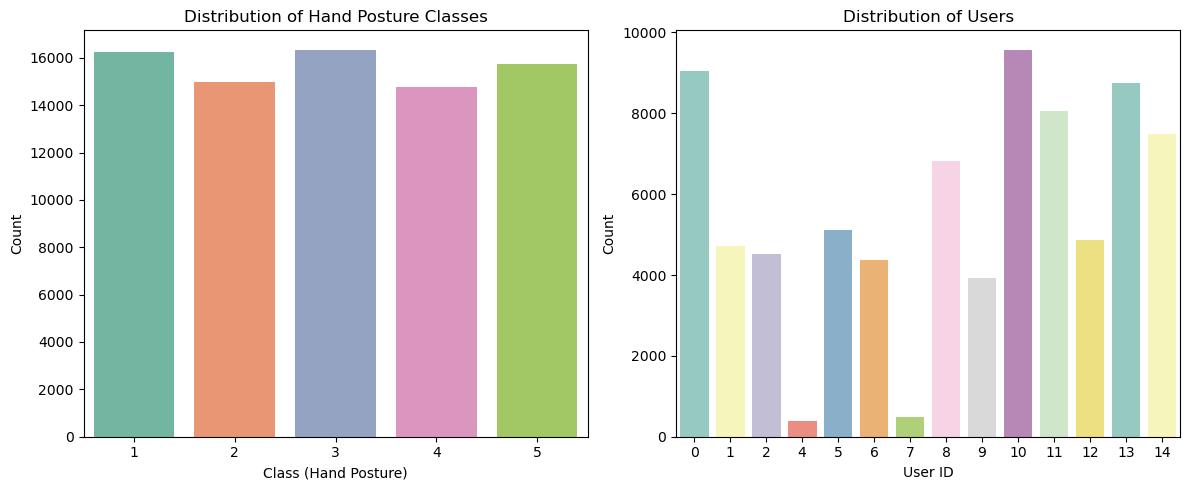

In [5]:
# add your code below
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# read file
df = pd.read_csv("data/Postures.csv")
# convert ? to NA, because there are many '?' exist in the dataset
df = df.replace('?', np.nan)
df.dropna(inplace=True, axis=1) # since drop all columns, set axis=1
df = df.drop(index=0) # because the 1st row is all 0
print(df.head())

plt.figure(figsize=(12, 5))

# --- Plot 1: Class distribution ---
plt.subplot(1, 2, 1)
sns.countplot(x='Class', hue='Class', data=df, palette='Set2', legend=False)
plt.title('Distribution of Hand Posture Classes')
plt.xlabel('Class (Hand Posture)')
plt.ylabel('Count')

# --- Plot 2: User distribution ---
plt.subplot(1, 2, 2)
sns.countplot(x='User', hue='User', data=df, palette='Set3', legend=False)
plt.title('Distribution of Users')
plt.xlabel('User ID')
plt.ylabel('Count')

plt.tight_layout()
plt.show()




## Problem 3a - basic splitting (5 points)

Create shuffled train/validation/test sets (60/20/20 ratio) and use `linear_ML_pipeline` to predict the class. 
Print out the best hyperparameter values, and the test score.
Repeat this process with 5 random states and report the mean and stdev of the test score.

You may receive some warnings about models failing to converge. This usually happens when C is too high (aka not enough regularization). Play around with those parameters in `linear_ML_pipeline` until you no longer see that warning.

In [6]:
# add your code here
import numpy as np
from sklearn.model_selection import train_test_split

# Identify features (X) and target (y)
X = df.drop(columns=['Class'])
y = df['Class']

test_scores = []
# Loop over 5 random states
for seed in range(5):
    # Shuffle and Split data set: 60% train, 20% val, 20% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, shuffle=True, random_state=seed)

    # Call the linear_ML_pipeline
    best_model, best_params, test_score = linear_ML_pipeline(
        X_train, y_train, X_val, y_val, X_test, y_test,
        is_classif=True,
        continuous_ftrs=[col for col in X.columns if col != 'User'],
        ordinal_ftrs=[], ordinal_cats=[], categorical_ftrs=['User']
    )

    # Record test accuracy
    test_scores.append(test_score)
    print("Best Hyperparameter and Test Accuracy: "
      f"C={float(best_params['C']):.3f}, "
      f"l1_ratio={float(best_params['l1_ratio']):.2f}, "
      f"test accuracy={test_score:.4f}")


print(f"\nMean test accuracy = {np.mean(test_scores):.4f}, std = {np.std(test_scores):.4f}")


Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=0.10, test accuracy=0.5676
Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=0.10, test accuracy=0.5765
Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=0.78, test accuracy=0.5683
Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=0.10, test accuracy=0.5694
Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=0.33, test accuracy=0.5760

Mean test accuracy = 0.5716, std = 0.0039


### Problem 3b (10 points)

How would you split the dataset if we wanted to know how accurately we can predict the hand postures of a new, previously unseen user? What's the target variable? Write down your reasoning (the usual 1-2 paragraphs are fine). Split the dataset into training, validation, and test sets, and run `linear_ML_pipeline` on it.

**Add your explanation here:**


In this task, the goal is to evaluate how well the model can predict the hand postures of a previously unseen user. Therefore, the target variable (y) is the hand posture class 'Class'. Since we want to simulate predicting for a new user not seen during training, we must ensure that no user appears in more than one split. To achieve this, the dataset is split by 'User' rather than by individual samples, preventing data leakage across the same user’s data. We use nested GroupShuffleSplit to create approximately a 60/20/20 ratio for training, validation, and test sets. The outer split (80/20) separates users for testing, while the inner split (75/25) divides the remaining users into training and validation subsets. This approach ensures that the model is evaluated on completely unseen users, making the test accuracy a realistic estimate of the model’s ability to generalize across people.



In [ ]:
# add your code here
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
# Define X,y, group
groups = df['User']
X = df.drop(columns=['Class', 'User'])
y = df['Class']
# Create a list to store resule
test_scores = []
for seed in range(5):
    # Outer split: separate test users (20%)
    outer_gss = GroupShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=seed)
    trainval_idx, test_idx = next(outer_gss.split(X, y, groups))
    
    X_trainval, X_test = X.iloc[trainval_idx], X.iloc[test_idx]
    y_trainval, y_test = y.iloc[trainval_idx], y.iloc[test_idx]
    groups_trainval = groups.iloc[trainval_idx]
    
    # Inner split: from the remaining 80%, split train/val (75/25) -> 60/20 overall
    inner_gss = GroupShuffleSplit(n_splits=1, train_size=0.75, test_size=0.25, random_state=seed)
    train_idx, val_idx = next(inner_gss.split(X_trainval, y_trainval, groups_trainval))

    X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    # Run pipeline
    best_model, best_params, test_score = linear_ML_pipeline(
        X_train, y_train, X_val, y_val, X_test, y_test,
        is_classif=True,
        continuous_ftrs=list(X.columns),
        ordinal_ftrs=[], ordinal_cats=[], categorical_ftrs=[]
    )

    test_scores.append(test_score)
    print("Best Hyperparameter and Test Accuracy: "
      f"C={float(best_params['C']):.3f}, "
      f"l1_ratio={float(best_params['l1_ratio']):.2f}, "
      f"test accuracy={test_score:.4f}")


print(f"\nGroup-based split: mean test accuracy = {np.mean(test_scores):.4f}, std = {np.std(test_scores):.4f}")


Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=1.00, test accuracy=0.4562
Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=0.10, test accuracy=0.4562
Best Hyperparameter and Test Accuracy: C=0.010, l1_ratio=0.33, test accuracy=0.4747
Best Hyperparameter and Test Accuracy: C=0.010, l1_ratio=0.10, test accuracy=0.5167
Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=0.10, test accuracy=0.4797

Group-based split: mean test accuracy = 0.4767, std = 0.0222


### Problem 3c (10 points)

How would you split the data if we wanted to identify a user based on their hand postures? What's the target variable? Follow the same steps as in 3b (explain your reasoning, split, and run `linear_ML_pipeline`).

**Add your explanation here:**

The goal of this task is to determine which user performed a given hand posture. Therefore, the target variable (y) is 'User'. Since each user contributed a different number of samples, the dataset is highly unbalanced, some users (e.g., ID 10 and 0) have over 9,000 samples, whereas others (such as ID 4 and 7) have only a few hundred. To prevent the training and validation sets from being dominated by these majority users, we employ a stratified split. This approach maintains approximately the same user-label distribution in the training, validation, and test sets, ensuring that minority users are still represented. We first perform an 80/20 stratified split to separate the test set and then apply Stratified K-Fold (5 folds) on the remaining 80 percent to obtain training and validation sets. This way, each fold respects the user-frequency balance while allowing cross-validated evaluation of model stability. In the linear_ML_pipeline, we treat the numeric sensor variables as continuous features and the Class column as a categorical feature, enabling the model to learn how each user uniquely performs the same hand posture.


In [6]:
# add your code here

from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define target (y) and features (X)
X = df.drop(columns=['User'])
y = df['User']
test_scores = []

for seed in range(5):
    # stratified 80/20 split for test set
    X_other, X_test, y_other, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed)

    # StratifiedKFold on remaining 80% (to get train/val)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for fold, (train_index, val_index) in enumerate(kf.split(X_other, y_other)):
        X_train = X_other.iloc[train_index]
        y_train = y_other.iloc[train_index]
        X_val = X_other.iloc[val_index]
        y_val = y_other.iloc[val_index]

    # Run pipeline
    best_model, best_params, test_score = linear_ML_pipeline(
        X_train, y_train, X_val, y_val, X_test, y_test,
        is_classif=True,
        continuous_ftrs=[col for col in X.columns if col != 'Class'],
        ordinal_ftrs=[], ordinal_cats=[], categorical_ftrs=['Class'])

    test_scores.append(test_score)
    print("Best Hyperparameter and Test Accuracy: "
          f"C={float(best_params['C']):.3f}, "
          f"l1_ratio={float(best_params['l1_ratio']):.2f}, "
          f"test accuracy={test_score:.4f}")

print(f"\nStratified split: mean test accuracy = {np.mean(test_scores):.4f}, "
      f"std = {np.std(test_scores):.4f}")



Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=0.10, test accuracy=0.2599
Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=1.00, test accuracy=0.2616
Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=0.10, test accuracy=0.2592
Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=0.78, test accuracy=0.2637
Best Hyperparameter and Test Accuracy: C=10.000, l1_ratio=0.33, test accuracy=0.2685

Stratified split: mean test accuracy = 0.2626, std = 0.0033
